# MuseX Tutorial, with a Photutils catalog

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import tempfile

Create a temporary directory in which all files will be stored.

In [2]:
tmpdir = tempfile.TemporaryDirectory(prefix='musex.')
tmpdir

<TemporaryDirectory '/tmp/simon/musex.h8dcvmeg'>

## Settings

The settings are specified in a YAML file. MuseX comes with a default settings file (`musex/musex/udf/settings.yaml`) that gives a full example for the UDF, with HST priors.

For this tutorial, we use the settings file from the `tests/` directory. The data inside this directory is extracted from the HDFS v1.24 dataset, and the catalog was created with [Photutils](http://photutils.readthedocs.io/).

In [3]:
import musex

In [4]:
DATADIR = os.path.abspath(os.path.join(os.path.dirname(musex.__file__), '..', 'tests', 'data'))
DATADIR

'/home/simon/dev/musex/tests/data'

Let's create a settings file in the temp directory, with correct paths.

In [5]:
settings_file = os.path.join(tmpdir.name, 'settings.yaml')
with open(os.path.join(DATADIR, 'settings.yaml'), 'r') as f:
    out = f.read().format(tmpdir=tmpdir.name, datadir=DATADIR, db=os.path.join(tmpdir.name, 'test.db'))
with open(settings_file, 'w') as f:
    f.write(out)
    
print(out)

workdir: '/tmp/simon/musex.h8dcvmeg'
db: '/tmp/simon/musex.h8dcvmeg/test.db'
show_banner: true
author: 'John Doe'

datasets:
  test:
    version: '1.0'
    prefix: TEST
    images:
      FAKE: '/home/simon/dev/musex/tests/data/image.fits'

muse_datasets:
  default: hdfs

  hdfs:
    version: '1.24'
    prefix: MUSE
    datacube: '/home/simon/dev/musex/tests/data/cube.fits'
    # expcube: '/home/simon/dev/musex/tests/data/expcube.fits'
    expima: '/home/simon/dev/musex/tests/data/expima.fits'
    white: '/home/simon/dev/musex/tests/data/image.fits'

catalogs:
  photutils:
    version: '1.0'
    catalog: '/home/simon/dev/musex/tests/data/catalog.fits'
    idname: id
    raname: ra
    decname: dec
    segmap: '/home/simon/dev/musex/tests/data/segmap.fits'
    extract:
      prefix: PHU
      columns: [id, ra, dec, source_sum, area]
      select_in: TEST_FAKE
  origin:
    class: musex.catalog.InputCatalog
    version: '1.0'
    catalog: '/home/simon/dev/musex/tests/data/cat_origin.fits'

## Create the MuseX object

This is the main object to manage all the extraction process below. Settings can also be overridden with additional arguments.

In [6]:
mx = musex.MuseX(settings_file=settings_file, author='SCO')

[INFO] Input catalogs loaded
[INFO] User catalogs loaded

  __  __               __  __
  |  \/  |_   _ ___  ___\ \/ /
  | |\/| | | | / __|/ _ \\  /
  | |  | | |_| \__ \  __//  \
  |_|  |_|\__,_|___/\___/_/\_\


The MUse Source EXtractor :) - v0.2.dev145+g21d6fca.d20190304

settings file  : /tmp/simon/musex.h8dcvmeg/settings.yaml
muse_dataset   : hdfs
datasets       : test
input_catalogs : photutils, origin
catalogs       : 


## Datasets

A MuseX object can contains several *datasets*, where a `DataSet` object gathers all the data from a dataset:

- For MUSE datasets: image, cube, exposure map.
- For other datasets (e.g. HST): images, ...

A MuseX object is tied to a given *Muse dataset* (`mx.muse_dataset`). The other datasets are typically added to the sources object during the extraction.

In [7]:
# The MUSE dataset
mx.muse_dataset

<MuseDataSet(MUSE, version 1.24, 0 images)

In [8]:
mx.muse_dataset.cube

<Cube(shape=(200, 90, 90), unit='1e-20 erg / (Angstrom cm2 s)', dtype='None')>

In [9]:
# The other (additional) datasets
mx.datasets

{'test': <DataSet(TEST, version 1.0, 1 images)}

In [10]:
mx.datasets['test'].images

{'FAKE': <Image(shape=(90, 90), unit='1e-60 erg / (Angstrom cm2 s)', dtype='None')>}

## Input Catalogs (from source detection, here Photutils)

We have access to a list of input catalogs, defined in the settings file. For the example, the catalog was from the Photutils detection code.

In [11]:
mx.input_catalogs

{'photutils': <InputCatalog('photutils', 0 rows)>,
 'origin': <InputCatalog('origin', 0 rows)>}

In [12]:
photcat = mx.input_catalogs['photutils']

At this point, the catalog is given as a FITS file defined in the settings, and we need to load it in the database.

In [13]:
photcat.ingest_input_catalog()

[INFO] ingesting catalog /home/simon/dev/musex/tests/data/catalog.fits



[INFO] 13 rows inserted


In [14]:
photcat

<InputCatalog('photutils', 13 rows)>

### See available columns, table info

This gives some information about our catalog: number of rows, columns, and some metadata.

In [15]:
photcat.info()

InputCatalog 'photutils' - 13 rows.

Workdir: 

Metadata:
- creation_date : 2019-04-09T10:00:14.116167
- type          : input
- parent_cat    : None
- raname        : ra
- decname       : dec
- idname        : id
- maxid         : 13
- segmap        : /home/simon/dev/musex/tests/data/segmap.fits
- query         : None
- dataset       : None
- convolve_fwhm : None
- psf_threshold : None
- mask_size_x   : None
- mask_size_y   : None
- src_idname    : None

Columns:
- id             : INTEGER 
- ra             : FLOAT 
- dec            : FLOAT 
- xcentroid      : FLOAT 
- ycentroid      : FLOAT 
- source_sum     : FLOAT 
- source_sum_err : FLOAT 
- area           : FLOAT 
- eccentricity   : FLOAT 
- orientation    : FLOAT 
- ellipticity    : FLOAT 
- elongation     : FLOAT 
- version        : TEXT 



## Intro to `Catalog` objects

In MuseX, `Catalog` objects are wrapping a SQL table, using the [SQLAlchemy](http://docs.sqlalchemy.org/en/latest/index.html) package. SQLAlchemy provides a Pythonic interface to the SQL language, and MuseX also provides some higher-level operations.

For instance, to select in the catalog the sources with an ``ID < 5``:

In [16]:
res = photcat.select(whereclause=photcat.c.id < 5, 
                     columns=[photcat.idname, photcat.raname, photcat.decname])
res

<ResultSet(photutils.id < 5)>, 4 results

The result of a selection can be exported as Astropy Table (or the `mpdaf.sdetect.Catalog` wrapper by default).
This shows the complete catalog:

In [17]:
photcat.select().as_table()

id,ra,dec,xcentroid,ycentroid,source_sum,source_sum_err,area,eccentricity,orientation,ellipticity,elongation,version
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3
1,338.22216683331436,-60.56791899034823,84.17464353709585,37.8735833857062,17.611382994800806,3.8582196214768953,79.0,0.43393342946114793,0.8580410669352785,0.09905506339394576,1.1099457462595834,1.0
2,338.223717115442,-60.566030603445334,70.39134668054363,71.85060521460757,5.36989851295948,2.3579307859187533,28.0,0.5278369963327637,-0.3707806312431074,0.1506543075387936,1.1773769018622235,1.0
3,338.23122540134506,-60.565947622439595,3.8983534121084236,73.12238343040192,7.717203065752983,2.5785737182307544,37.0,0.37486045077163443,-1.5044325003438939,0.07291875089219557,1.078654110373142,1.0
4,338.23075897015997,-60.56529582206629,8.008507386689562,84.87964684116072,47.56456159427762,3.957137899405799,86.0,0.3618120741766021,1.253981251781708,0.06774894852297164,1.0726724291870011,1.0
5,338.22344426453924,-60.565293950723195,72.78604306409346,85.1304977128141,9.267546605318785,2.891929673071918,43.0,0.34149582905403886,-0.7723162773518457,0.060116710043904065,1.063961888339043,1.0
6,338.23006974404103,-60.56947389750513,14.242037102996946,9.62603692085029,65.34346552938223,4.843022140700766,129.0,0.3788811153062252,-1.56822411586026,0.07455464749975071,1.080560831926303,1.0
7,338.2302119381167,-60.5687317201611,12.959857008648024,22.993210706363516,129.69185087271035,7.112266323040305,284.0,0.4017365013359274,0.4063112561507294,0.08424469234714871,1.0919947628401676,1.0
8,338.2289866204975,-60.56824280312122,23.794820877858843,31.838575804582526,3.1225252524018288,2.0181706293187514,25.0,0.693823639780682,1.2360735732899375,0.2798550445351391,1.38860932429151,1.0
9,338.2256990939331,-60.56919605095256,52.93434534163357,14.762051380534484,27.56038597226143,4.0427991796868215,88.0,0.5158184032950975,-0.3097023334651164,0.14330205158288356,1.1672725513673243,1.0


It is possible to do any SQL selection and choose which columns to get, using the SQLAlchemy syntax:

In [18]:
photcat.select(whereclause=photcat.c.source_sum > 50,
               columns=[photcat.idname, photcat.raname, photcat.decname, 'source_sum', 'area']).as_table()

id,ra,dec,source_sum,area
int64,float64,float64,float64,float64
6,338.23006974404103,-60.56947389750513,65.34346552938223,129.0
7,338.2302119381167,-60.5687317201611,129.69185087271035,284.0


## User catalogs

Input catalogs are kept immutable, instead users can work on a *"user catalog"*. 

User catalogs must be created with the result of a selection. The mandatory columns are `ID`, `RA` and `DEC` (the other columns from the input catalog can be accessed later with a SQL *join*).

So we can create a user catalog named `my_cat`:

In [19]:
res = photcat.select(columns=[photcat.idname, photcat.raname, photcat.decname])
mycat = mx.new_catalog_from_resultset('my_cat', res, drop_if_exists=True)


[INFO] 13 rows inserted


And we can look at the metadata which is stored about our new user catalog:

In [20]:
mycat.info()

Catalog 'my_cat' - 13 rows.

Workdir: /tmp/simon/musex.h8dcvmeg/my_cat

Metadata:
- creation_date : 2019-04-09T10:00:22.378380
- type          : user
- parent_cat    : photutils
- raname        : ra
- decname       : dec
- idname        : id
- maxid         : 13
- segmap        : /home/simon/dev/musex/tests/data/segmap.fits
- query         : None
- dataset       : None
- convolve_fwhm : None
- psf_threshold : None
- mask_size_x   : None
- mask_size_y   : None
- src_idname    : None

Columns:
- id  : INTEGER 
- ra  : FLOAT 
- dec : FLOAT 



Note that the segmentation map is inherited from the parent input catalog.

* * * 

## Restart and use existing catalog (created at previous step)

All of the above is a setup that has to be done only once. Then all the information is stored in the database. Let's restart with a new MuseX object to check that it works.

In [21]:
import musex
mx = musex.MuseX(settings_file=settings_file)

[INFO] Input catalogs loaded
[INFO] User catalogs loaded

  __  __               __  __
  |  \/  |_   _ ___  ___\ \/ /
  | |\/| | | | / __|/ _ \\  /
  | |  | | |_| \__ \  __//  \
  |_|  |_|\__,_|___/\___/_/\_\


The MUse Source EXtractor :) - v0.2.dev145+g21d6fca.d20190304

settings file  : /tmp/simon/musex.h8dcvmeg/settings.yaml
muse_dataset   : hdfs
datasets       : test
input_catalogs : photutils, origin
catalogs       : my_cat


User catalogs are stored in `mx.catalogs`:

In [22]:
mycat = mx.catalogs['my_cat']

And we can verify that our sources are still here:

In [23]:
mycat.select(limit=2).as_table()

id,ra,dec
int64,float64,float64
1,338.22216683331436,-60.56791899034823
2,338.223717115442,-60.566030603445334


## Preprocessing (segmap, masks, ...)

To do a proper spectrum extraction we need masks of the objects and background. These masks are pre-computed from a segmentation map, and they can be convolved to take into account the PSF of MUSE if the segmap comes from another instrument (e.g. HST).
The masks are also aligned with the MUSE field if needed (rotated and resampled). To do this we **attach a MUSE dataset  to a user catalog**.

In [24]:
mycat.attach_dataset(mx.muse_dataset, skip_existing=False)

[INFO] 13 sources inside dataset (13 in catalog)
[INFO] Aligning segmap with dataset hdfs
[DEBUG] creating sky mask


[DEBUG] source 1 (338.22217, -60.56792), extract mask (79 masked pixels)
[DEBUG] source 2 (338.22372, -60.56603), extract mask (28 masked pixels)
[DEBUG] source 3 (338.23123, -60.56595), extract mask (37 masked pixels)
[DEBUG] source 4 (338.23076, -60.56530), extract mask (86 masked pixels)
[DEBUG] source 5 (338.22344, -60.56529), extract mask (43 masked pixels)
[DEBUG] source 6 (338.23007, -60.56947), extract mask (129 masked pixels)
[DEBUG] source 7 (338.23021, -60.56873), extract mask (284 masked pixels)
[DEBUG] source 8 (338.22899, -60.56824), extract mask (25 masked pixels)
[DEBUG] source 9 (338.22570, -60.56920), extract mask (88 masked pixels)
[DEBUG] source 10 (338.22649, -60.56902), extract mask (23 masked pixels)
[DEBUG] source 11 (338.22348, -60.56754), extract mask (134 masked pixels)
[DEBUG] source 12 (338.22451, -60.56726), extract mask (92 masked pixels)
[DEBUG] source 13 (338.22461, -60.56671), extract mask (39 masked pixels)

[INFO] computed 13 sources: array([1, 2, 3,

The generated files are stored in the *work directory* and are generated only if needed:

In [25]:
print('work dir:', mycat.workdir)

os.listdir(mycat.workdir / mx.muse_dataset.name)

work dir: /tmp/simon/musex.h8dcvmeg/my_cat


['mask-source-00013.fits',
 'mask-source-00012.fits',
 'mask-source-00011.fits',
 'mask-source-00010.fits',
 'mask-source-00009.fits',
 'mask-source-00008.fits',
 'mask-source-00007.fits',
 'mask-source-00006.fits',
 'mask-source-00005.fits',
 'mask-source-00004.fits',
 'mask-source-00003.fits',
 'mask-source-00002.fits',
 'mask-source-00001.fits',
 'mask-sky.fits']

In [26]:
mycat.attach_dataset(mx.muse_dataset, skip_existing=True)

[INFO] 13 sources inside dataset (13 in catalog)
[DEBUG] sky mask exists, skipping
[INFO] skipped 13 sources: array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype=object)


The paths to the masks are stored in the database, and can be modified later if needed (the sky mask is the same for all sources by default, but it is possible to create a sky mask specific to a given source):

In [27]:
mycat.select(limit=2).as_table()

id,ra,dec,mask_obj,mask_sky
int64,float64,float64,str27,str18
1,338.22216683331436,-60.56791899034823,hdfs/mask-source-00001.fits,hdfs/mask-sky.fits
2,338.223717115442,-60.566030603445334,hdfs/mask-source-00002.fits,hdfs/mask-sky.fits


## Origin

We also have the possibility to ingest a catalog from the ORIGIN detection software. This catalog is associated to a line catalog, which contains the individual line detections.

In [28]:
origcat = mx.input_catalogs['origin']

In [29]:
origcat.ingest_input_catalog()

[INFO] ingesting catalog /home/simon/dev/musex/tests/data/cat_origin.fits



[INFO] 10 rows inserted
[INFO] ingesting line table /home/simon/dev/musex/tests/data/cat_origin_lines.fits



[INFO] 13 rows inserted


In [30]:
myori = mx.new_catalog_from_resultset('my_oricat', origcat.select())


[INFO] 10 rows inserted


The ORIGIN input data also includes pre-generated masks, which are defined in the YAML file with ``mask_tpl`` and ``skymask_tpl``.

In [31]:
myori.attach_dataset(mx.muse_dataset, skip_existing=True)

[INFO] 10 sources inside dataset (10 in catalog)
[INFO] copied 10 sources: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=object)


In [32]:
myori.select(limit=2).as_table()

ID,ra,dec,x,y,n_lines,seg_label,comp,line_merged_flag,version,mask_obj,mask_sky
int64,float64,float64,float64,float64,int64,int64,int64,bool,str3,str27,str18
0,338.23009603091447,-60.569175573853556,14.0,15.0,0,6,0,False,1.0,hdfs/mask-source-00000.fits,hdfs/mask-sky.fits
1,338.228065721342,-60.569900508634014,32.0,2.0,0,0,0,False,1.0,hdfs/mask-source-00001.fits,hdfs/mask-sky.fits


## MarZ export and import

First, we need to set the `REFSPEC` column to tell which spectrum must be used : (this may change later to allow more flexibility, currently it is possible to set a `refspec` value for each source).

In [33]:
mycat.update_column('refspec', 'MUSE_PSF_SKYSUB')

[INFO] creating column 'my_cat.refspec'


In [34]:
mx.export_marz(mycat)

[INFO] Saving sources to /tmp/simon/musex.h8dcvmeg/export/hdfs/my_cat/marz/source-{src.ID:05d}.fits
[INFO] Exporting 13 sources with hdfs dataset, size=5.0
[WARNING] 'QOP' column not found, though it is specified in the settings file for the CONFID keyword
[WARNING] 'Blend' column not found, though it is specified in the settings file for the BLEND keyword
[WARNING] 'Defect' column not found, though it is specified in the settings file for the DEFECT keyword
[WARNING] 'Revisit' column not found, though it is specified in the settings file for the REVISIT keyword
[WARNING] 'Type' column not found, though it is specified in the settings file for the TYPE keyword
[WARNING] 'Comment' column not found, though it is specified in the settings file for the COMMENT keyword



[INFO] Writing /tmp/simon/musex.h8dcvmeg/export/hdfs/my_cat/marz/marz-my_cat-hdfs.fits


Once the spectra have been processed in MarZ, the results file can be ingested into MuseX:

In [35]:
mx.import_marz(os.path.join(DATADIR, 'marz-my-cat-hdfs_full_SCO.mz'), mycat)

[INFO] ingesting catalog



[INFO] 13 rows inserted


In [36]:
mx.marzcat.info()

MarzCatalog 'marz' - 13 rows.

Workdir: 

Metadata:
- creation_date : 2019-04-09T10:00:53.575073
- type          : marz
- parent_cat    : None
- raname        : RA
- decname       : DEC
- idname        : ID
- maxid         : 13
- segmap        : None
- query         : None
- dataset       : None
- convolve_fwhm : None
- psf_threshold : None
- mask_size_x   : None
- mask_size_y   : None
- src_idname    : None
- version_meta  : None
- CAT3_TS       : None

Columns:
- _id      : INTEGER 
- ID       : INTEGER 
- RA       : FLOAT 
- DEC      : FLOAT 
- Mag      : FLOAT 
- Type     : INTEGER 
- AutoTID  : INTEGER 
- AutoTN   : TEXT 
- AutoZ    : FLOAT 
- AutoXCor : FLOAT 
- FinTID   : INTEGER 
- FinTN    : TEXT 
- FinZ     : FLOAT 
- QOP      : INTEGER 
- Blend    : INTEGER 
- Defect   : INTEGER 
- Revisit  : INTEGER 
- HstIds   : TEXT 
- Comment  : TEXT 
- catalog  : TEXT 
- version  : TEXT 



In [37]:
mx.marzcat.select(limit=3).as_table()

_id,ID,RA,DEC,Mag,Type,AutoTID,AutoTN,AutoZ,AutoXCor,FinTID,FinTN,FinZ,QOP,Blend,Defect,Revisit,HstIds,Comment,catalog,version
int64,int64,float64,float64,float64,int64,int64,str55,float64,float64,int64,str55,float64,int64,int64,int64,int64,str5,str1,str6,str1
1,1,338.222167,-60.567919,-99.0,0,11,MUSE-35 HDF-S z-bin 1 - Ha emitter,-0.00258,9.79608,11,MUSE-35 HDF-S z-bin 1 - Ha emitter,-0.00258,2,0,0,0,--,--,my_cat,1
2,2,338.223717,-60.566031,-99.0,2,14,MUSE-38 HDF-S z-bin 3 - [O II] emitter - weak continuum,0.31325,11.90192,14,MUSE-38 HDF-S z-bin 3 - [O II] emitter - weak continuum,0.31325,2,0,0,0,24348,--,my_cat,1
3,3,338.231225,-60.565948,-99.0,6,18,MUSE-42 HDF-S z-bin 5 - Ly-a emitter - weak continuum,3.0343,25.8933,18,MUSE-42 HDF-S z-bin 5 - Ly-a emitter - weak continuum,3.0343,3,0,0,0,24353,--,my_cat,1


## Joining catalogs

When the user catalog is ready to be exported, one need to gather the data from multiple catalogs (the input catalog, MarZ, etc.). This can be done with a SQL *join*.

By default `.join` renames the columns with the format `{catname}_{colname}` to avoid name conflicts. But it is also possible to specify manually the column names (see below).

In [38]:
res = mycat.join([photcat, mx.marzcat], whereclause=(mx.marzcat.c.catalog == mycat.name))
res.as_table()[:2]

my_cat_id,my_cat_ra,my_cat_dec,my_cat_mask_obj,my_cat_mask_sky,my_cat_refspec,photutils_id,photutils_ra,photutils_dec,photutils_xcentroid,photutils_ycentroid,photutils_source_sum,photutils_source_sum_err,photutils_area,photutils_eccentricity,photutils_orientation,photutils_ellipticity,photutils_elongation,photutils_version,marz__id,marz_ID,marz_RA,marz_DEC,marz_Mag,marz_Type,marz_AutoTID,marz_AutoTN,marz_AutoZ,marz_AutoXCor,marz_FinTID,marz_FinTN,marz_FinZ,marz_QOP,marz_Blend,marz_Defect,marz_Revisit,marz_HstIds,marz_Comment,marz_catalog,marz_version
int64,float64,float64,str27,str18,str15,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,int64,int64,float64,float64,float64,int64,int64,str57,float64,float64,int64,str57,float64,int64,int64,int64,int64,str5,str1,str6,str1
1,338.22216683331436,-60.56791899034823,hdfs/mask-source-00001.fits,hdfs/mask-sky.fits,MUSE_PSF_SKYSUB,1,338.22216683331436,-60.56791899034823,84.17464353709585,37.8735833857062,17.611382994800806,3.8582196214768953,79.0,0.43393342946114793,0.8580410669352785,0.09905506339394576,1.1099457462595834,1.0,1,1,338.222167,-60.567919,-99.0,0,11,MUSE-35 HDF-S z-bin 1 - Ha emitter,-0.00258,9.79608,11,MUSE-35 HDF-S z-bin 1 - Ha emitter,-0.00258,2,0,0,0,--,--,my_cat,1
2,338.223717115442,-60.566030603445334,hdfs/mask-source-00002.fits,hdfs/mask-sky.fits,MUSE_PSF_SKYSUB,2,338.223717115442,-60.566030603445334,70.39134668054363,71.85060521460757,5.36989851295948,2.3579307859187533,28.0,0.5278369963327637,-0.3707806312431074,0.1506543075387936,1.1773769018622235,1.0,2,2,338.223717,-60.566031,-99.0,2,14,MUSE-38 HDF-S z-bin 3 - [O II] emitter - weak continuum,0.31325,11.90192,14,MUSE-38 HDF-S z-bin 3 - [O II] emitter - weak continuum,0.31325,2,0,0,0,24348,--,my_cat,1


## Select columns for the final catalog

To avoid column name conflicts, for now the user needs to select explicitely the columns and rename if needed. This must be done with SQLAlchemy columns objects:

In [39]:
str(photcat.c)

"['photutils.id', 'photutils.ra', 'photutils.dec', 'photutils.xcentroid', 'photutils.ycentroid', 'photutils.source_sum', 'photutils.source_sum_err', 'photutils.area', 'photutils.eccentricity', 'photutils.orientation', 'photutils.ellipticity', 'photutils.elongation', 'photutils.version']"

In [40]:
photcols = [photcat.c[name] for name in ['source_sum', 'source_sum_err', 'area', 'eccentricity', 
                                         'orientation', 'ellipticity', 'elongation', 'version']]

marzcols = [mx.marzcat.c[name] for name in ('FinZ', 'QOP', 'Type', 'Blend', 'Defect', 'Revisit', 'Comment')]

It is possible to rename a column with `.label`:

In [41]:
photcols[2] = photcols[2].label('pixel_area')

Then we concatenate the column names from the user catalog, MarZ, and the input catalog:

In [42]:
mycat.c + marzcols + photcols

[Column('id', INTEGER(), table=<my_cat>, primary_key=True, nullable=False),
 Column('ra', FLOAT(), table=<my_cat>),
 Column('dec', FLOAT(), table=<my_cat>),
 Column('mask_obj', TEXT(), table=<my_cat>),
 Column('mask_sky', TEXT(), table=<my_cat>),
 Column('refspec', TEXT(), table=<my_cat>),
 Column('FinZ', FLOAT(), table=<marz>),
 Column('QOP', INTEGER(), table=<marz>),
 Column('Type', INTEGER(), table=<marz>),
 Column('Blend', INTEGER(), table=<marz>),
 Column('Defect', INTEGER(), table=<marz>),
 Column('Revisit', INTEGER(), table=<marz>),
 Column('Comment', TEXT(), table=<marz>),
 Column('source_sum', FLOAT(), table=<photutils>),
 Column('source_sum_err', FLOAT(), table=<photutils>),
 Column('eccentricity', FLOAT(), table=<photutils>),
 Column('orientation', FLOAT(), table=<photutils>),
 Column('ellipticity', FLOAT(), table=<photutils>),
 Column('elongation', FLOAT(), table=<photutils>),
 Column('version', TEXT(), table=<photutils>)]

And we can proceed with the join. Note that by default the join uses the `id` column of each catalog, but it is possible to specify others keys with the `keys` arguments. Also, the `mx.marzcat` table can store the results for multiple catalogs, so we need to select the results for our catalog with the `whereclause`:

In [43]:
res = mycat.join(
    [mx.marzcat, photcat], 
    whereclause=(mx.marzcat.c.catalog == mycat.name), 
    columns=mycat.c + marzcols + photcols, 
    use_labels=False
).as_table()
res[:3]

id,ra,dec,mask_obj,mask_sky,refspec,FinZ,QOP,Type,Blend,Defect,Revisit,Comment,source_sum,source_sum_err,pixel_area,eccentricity,orientation,ellipticity,elongation,version
int64,float64,float64,str27,str18,str15,float64,int64,int64,int64,int64,int64,str1,float64,float64,float64,float64,float64,float64,float64,str3
1,338.22216683331436,-60.56791899034823,hdfs/mask-source-00001.fits,hdfs/mask-sky.fits,MUSE_PSF_SKYSUB,-0.00258,2,0,0,0,0,--,17.611382994800806,3.8582196214768953,79.0,0.43393342946114793,0.8580410669352785,0.09905506339394576,1.1099457462595834,1.0
2,338.223717115442,-60.566030603445334,hdfs/mask-source-00002.fits,hdfs/mask-sky.fits,MUSE_PSF_SKYSUB,0.31325,2,2,0,0,0,--,5.36989851295948,2.3579307859187533,28.0,0.5278369963327637,-0.3707806312431074,0.1506543075387936,1.1773769018622235,1.0
3,338.23122540134506,-60.565947622439595,hdfs/mask-source-00003.fits,hdfs/mask-sky.fits,MUSE_PSF_SKYSUB,3.0343,3,6,0,0,0,--,7.717203065752983,2.5785737182307544,37.0,0.37486045077163443,-1.5044325003438939,0.07291875089219557,1.078654110373142,1.0


## Export sources

In [44]:
# Set the REFSPEC column to tell which spectrum must be used 
# mycat.update_column('refspec', 'MUSE_PSF_SKYSUB')

Currently, to get a redshift and confidence number in the `Source` objects, MuseX looks at specific columns (`Z` and `Confid`) in the table. So here we rename the columns (we could have done this within the SQL join above, with `.label`):

In [45]:
res.rename_column('FinZ', 'Z')
res.rename_column('QOP', 'Confid')

And we do the export, here for only one source selected by its ID. We also ask for the creation of a PDF file with plots:

In [46]:
mx.export_sources(mycat.select_ids([1]), create_pdf=True, size=5, srcvers='0.1', apertures=[0.4])

[INFO] Exporting 1 sources with hdfs dataset, size=5.0
[WARNING] 'QOP' column not found, though it is specified in the settings file for the CONFID keyword
[WARNING] 'Blend' column not found, though it is specified in the settings file for the BLEND keyword
[WARNING] 'Defect' column not found, though it is specified in the settings file for the DEFECT keyword
[WARNING] 'Revisit' column not found, though it is specified in the settings file for the REVISIT keyword
[WARNING] 'Type' column not found, though it is specified in the settings file for the TYPE keyword
[WARNING] 'Comment' column not found, though it is specified in the settings file for the COMMENT keyword


The output files are placed in the *work directory*:

In [47]:
outdir = os.path.join(mx.workdir, 'export', mx.muse_dataset.name, mycat.name, 'sources')
outdir, os.listdir(outdir)

('/tmp/simon/musex.h8dcvmeg/export/hdfs/my_cat/sources',
 ['source-00001.pdf', 'source-00001.fits'])

A MPDAF source file has been generated, with all the information both in the header and in the extensions (images, spectra):

In [48]:
from mpdaf.sdetect import Source
Source.from_file(f'{outdir}/source-00001.fits').info()

[INFO] ID      =                    1 / object ID %d                                   
[INFO] RA      =    338.2221668333144 / RA u.degree %.7f                               
[INFO] DEC     =   -60.56791899034823 / DEC u.degree %.7f                              
[INFO] FROM    = 'MuseX   '           / detection software                             
[INFO] FROM_V  = '0.2.dev145+g21d6fca.d20190304' / version of the detection software   
[INFO] CUBE    = 'cube.fits'          / datacube                                       
[INFO] CUBE_V  = '1.24    '           / version of the datacube                        
[INFO] SRC_V   = '0.1     '           / Source Version                                 
[INFO] SIZE    =                    5                                                  
[INFO] EXPMEAN =                 51.0 / Mean value of EXPMAP                           
[INFO] EXPMIN  =                   51 / Minimum value of EXPMAP                        
[INFO] EXPMAX  =                

A PDF file was generated as well.

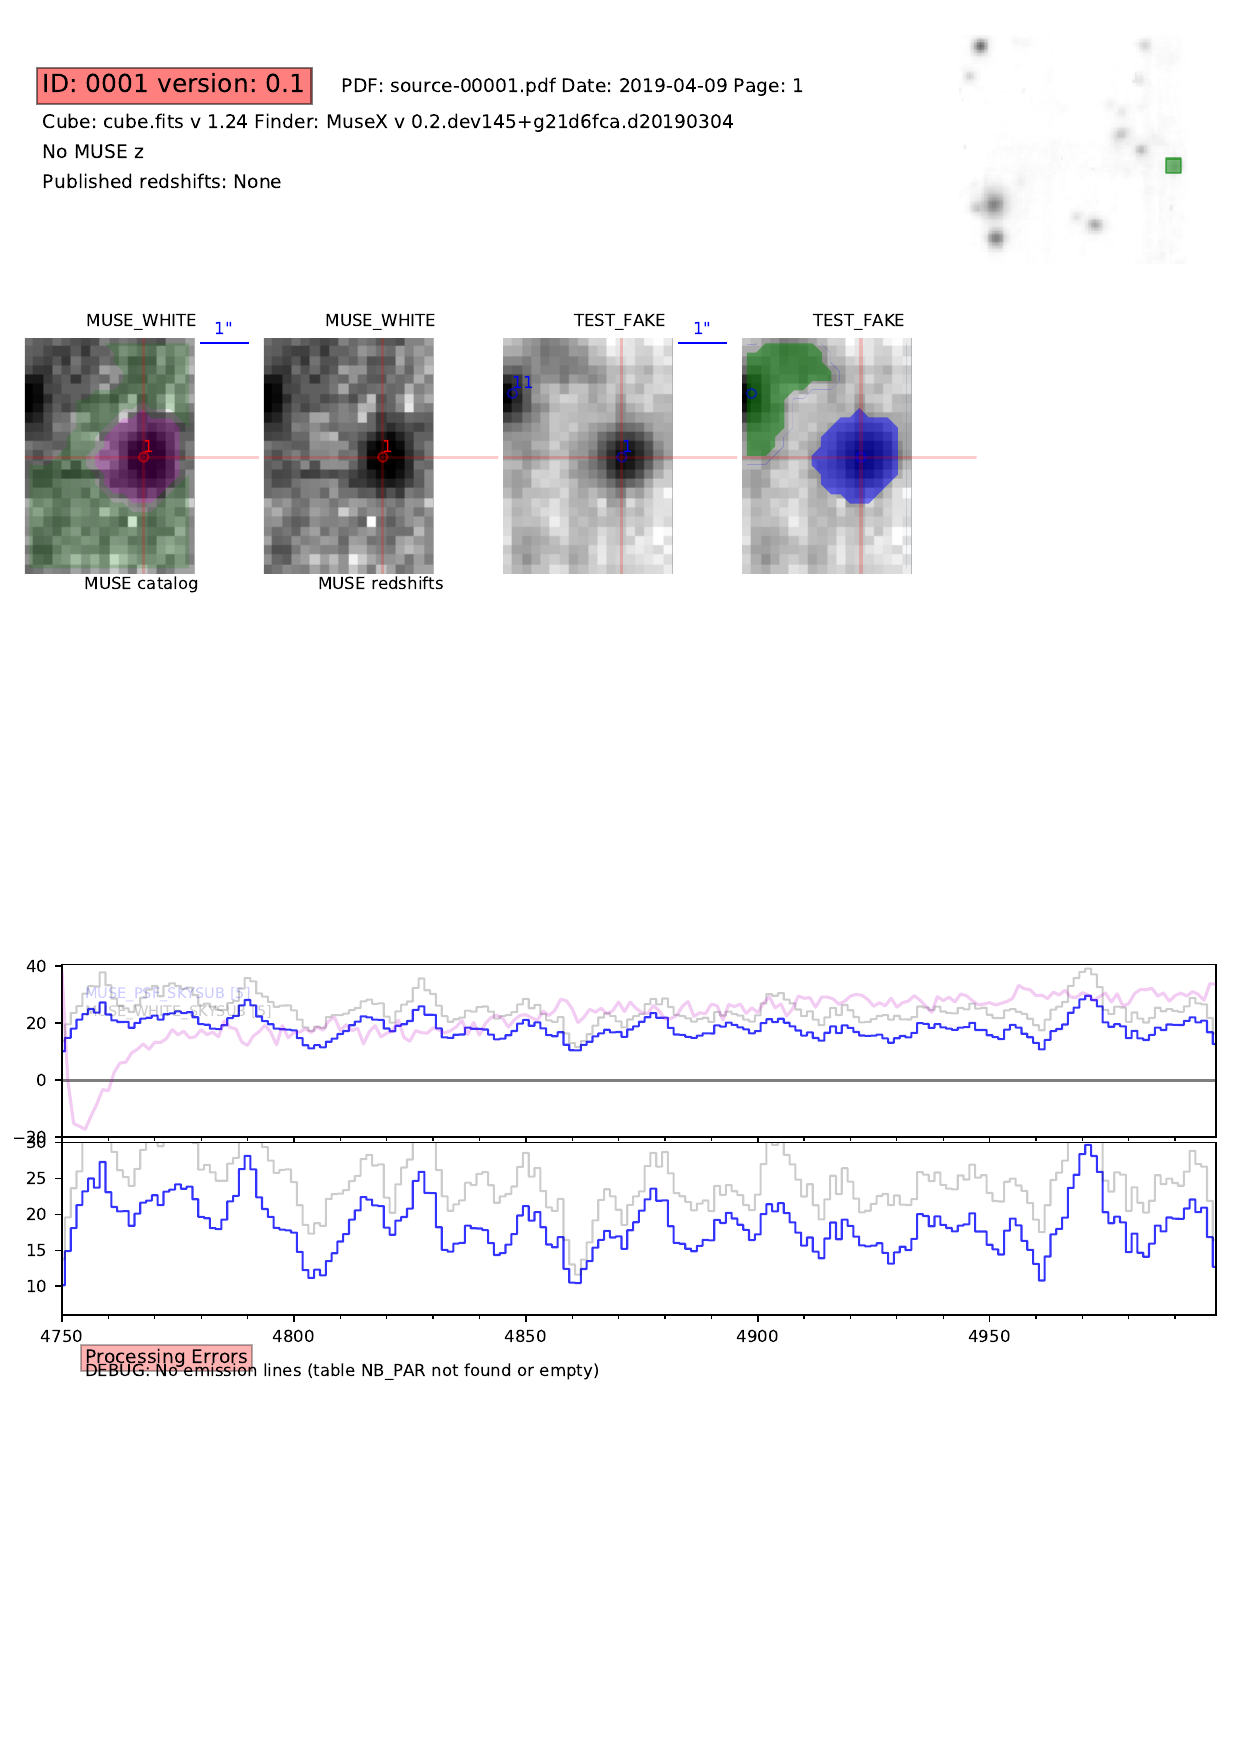

In [49]:
import subprocess
subprocess.run(f'pdftoppm -singlefile {outdir}/source-00001.pdf out && convert out.ppm out.png', shell=True)

from IPython.display import Image
display(Image('out.png'))

In [50]:
# import webbrowser
# webbrowser.open(f'{outdir}/source-00001.pdf')

In [51]:
# from IPython.display import IFrame
# display(IFrame(f'{outdir}/source-00001.pdf', width=600, height=300))

In [52]:
# Cleanup temp directory
tmpdir.cleanup()